In [1]:
#default_exp tests

# Tests
> Test ... test ... test ...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

dowhy references:
* Documentation: [here](https://microsoft.github.io/dowhy/)
* GitHub: [here](https://github.com/microsoft/dowhy)

Random references:
* average treatment effect: [wiki](https://en.wikipedia.org/wiki/Average_treatment_effect)
* backdoor path: [youtube video](https://www.youtube.com/watch?v=F8vcki-uWJc)
* propensity score (matching):
    * [wiki](https://en.wikipedia.org/wiki/Propensity_score_matching)
    * a not very clear medical [nih article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6760465/)
* the *do*-operator / interventions and counterfactuals: [article](https://www.ucl.ac.uk/lagnado-lab/publications/lagnado/intervention%20hagmayer%20et%20al.pdf)

**Content**
* create gml graph using networkx
* feature importance of features of the dataset using a random forest model
* basic dowhy tasks

**To do**
* learn the meaning of the estimations / output of `CausalModel.identify_effect`, `CausalModel.estimate_effect` and `CausalModel.refute_effect`
* learn how the estimated effect is calculated

In [2]:
#export
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets
import networkx as nx
from sklearn import ensemble, metrics
import typing
import itertools

In [3]:
#hide
mpl.style.use('bmh')

## /Generating a networx graph and exporting it into GML format

In [4]:
g = nx.DiGraph()
g.add_edges_from([('a', 'b')])

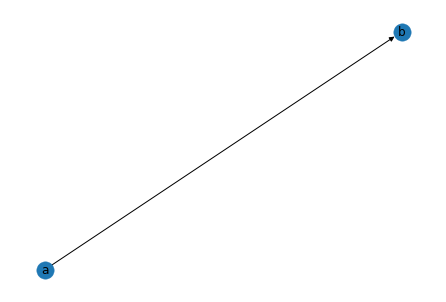

In [5]:
nx.draw(g, with_labels=True)

In [6]:
print(''.join([v for v in nx.readwrite.gml.generate_gml(g)]))

graph [  directed 1  node [    id 0    label "a"  ]  node [    id 1    label "b"  ]  edge [    source 0    target 1  ]]


## Regression & dowhy things for the `linear_dataset`

* `v`: treatment
* `y`: outcome
* `w`: common cause
* `z`: instrument
* `x`: effect modifier

In [7]:
#export
def stochastically_convert_to_binary(x:float):
    p = 1/(1+np.exp(-x))  # sigmoid
    return np.random.choice([0, 1], size=1, p=[1-p, p])

In [8]:
stochastically_convert_to_binary(1)

array([1])

In [18]:
#export
def create_nxgraph(treatments:typing.List[str], outcome:str, common_causes:typing.List[str],
                   instruments:typing.List[str], effect_modifiers:typing.List[str]=[],
                   unobs_conf:str="Unobserved Confounder"):
    'Created a specific directed acyclic graph used for the `create_linear_dataset` function.'
    g = nx.DiGraph()
    
    g.add_edge(unobs_conf, outcome)
    g.add_edges_from([(treatment, outcome) for treatment in treatments])
    g.add_edges_from([(unobs_conf, treatment) for treatment in treatments])
    g.add_edges_from([(common_cause, treatment) 
                      for common_cause, treatment in itertools.product(common_causes, treatments)])
    g.add_edges_from([(instrument, treatment) 
                      for instrument, treatment in itertools.product(instruments, treatments)])
    g.add_edges_from([(common_cause, outcome) for common_cause in common_causes])
    g.add_edges_from([(effect_modifier, outcome) for effect_modifier in effect_modifiers])
    return g

graph [  directed 1  node [    id 0    label "Unobserved Confounder"  ]  node [    id 1    label "y"  ]  node [    id 2    label "v0"  ]  node [    id 3    label "W0"  ]  node [    id 4    label "W1"  ]  node [    id 5    label "W2"  ]  node [    id 6    label "W3"  ]  node [    id 7    label "W4"  ]  node [    id 8    label "Z0"  ]  node [    id 9    label "Z1"  ]  node [    id 10    label "X0"  ]  edge [    source 0    target 1  ]  edge [    source 0    target 2  ]  edge [    source 2    target 1  ]  edge [    source 3    target 2  ]  edge [    source 3    target 1  ]  edge [    source 4    target 2  ]  edge [    source 4    target 1  ]  edge [    source 5    target 2  ]  edge [    source 5    target 1  ]  edge [    source 6    target 2  ]  edge [    source 6    target 1  ]  edge [    source 7    target 2  ]  edge [    source 7    target 1  ]  edge [    source 8    target 2  ]  edge [    source 9    target 2  ]  edge [    source 10    target 1  ]]


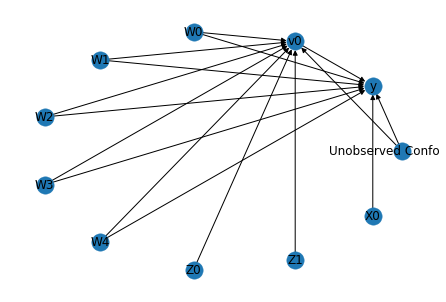

In [94]:
num_treatments = 1
num_common_causes = 5
num_instruments = 2
num_effect_modifiers = 1

effect_modifiers = [f'X{i}' for i in range(num_effect_modifiers)]
instruments = [f'Z{i}' for i in range(num_instruments)]
common_causes = [f'W{i}' for i in range(num_common_causes)]
treatments = [f'v{i}' for i in range(num_treatments)]
outcome = ['y']

g = create_nxgraph(treatments, outcome[0], common_causes, instruments, effect_modifiers)
print(''.join([v for v in nx.readwrite.gml.generate_gml(g)]))

nx.draw_circular(g, with_labels=True)
plt.show()

The linear model:
$$t = \varepsilon + W \cdot c_1 + Z \cdot c_z$$

$$y = t \cdot \beta + W \cdot c_2 + X \cdot c_e \cdot t$$

In [20]:
#export
def create_linear_dataset(beta:typing.Union[int,float,list,np.ndarray], 
                   num_treatments:int, num_common_causes:int, num_samples:int,
                   num_instruments:int, num_effect_modifiers:int,
                   treatment_is_binary:bool,
                   outcome_is_binary:bool):
    '''Generates data using a linear model
    
    treament: $t = \varepsilon + W \cdot c_1 + Z \cdot c_z$
    output: $y = t \cdot \beta + W \cdot c_2 + X \cdot c_e \cdot t$
    
    Names assigned in ret_dict['df']
    * `V`: treatment
    * `Y`: outcome
    * `W`: common cause
    * `Z`: instrument
    * `x`: effect modifier
    '''
    W, X, Z, c1, c2, ce, cz = [None]*7
    
    beta = float(beta)
    
    if not isinstance(beta, (list, np.ndarray)):
        beta = np.repeat(beta, num_treatments)
    
    if num_common_causes > 0:
        range_c1 = max(beta) * .5
        range_c2 = max(beta) * .5
        means = np.random.uniform(-1, 1, num_common_causes)
        cov_mat = np.diag(np.ones(num_common_causes))
        W = np.random.multivariate_normal(means, cov_mat, size=num_samples)
        c1 = np.random.uniform(0, range_c1, size=(num_common_causes, num_treatments))
        c2 = np.random.uniform(0, range_c2, size=num_common_causes)
        
    if num_instruments > 0:
        range_cz = beta
        p = np.random.uniform(0, 1, num_instruments)
        Z = np.zeros((num_samples, num_instruments))
        for i in range(num_instruments):
            if (i % 2) == 0:
                Z[:, i] = np.random.binomial(n=1, p=p[i], size=num_samples)  # ???
            else:
                Z[:, i] = np.random.uniform(0, 1, size=num_samples)  # ???
        # TODO Ensure that we do not generate weak instruments
        cz = np.random.uniform(low=range_cz - range_cz * .05,
                               high=range_cz + range_cz * .05, 
                               size=(num_instruments, num_treatments))
        
    if num_effect_modifiers >0:
        range_ce = beta * .5
        means = np.random.uniform(-1, 1, num_effect_modifiers)
        cov_mat = np.diag(np.ones(num_effect_modifiers))
        X = np.random.multivariate_normal(means, cov_mat, num_samples)
        ce = np.random.uniform(0, range_ce, num_effect_modifiers)
    # TODO - test all our methods with random noise added to covariates (instead of the stochastic treatment assignment)
    
    t = np.random.normal(0, 1, size=(num_samples, num_treatments))
    
    if num_common_causes > 0:
        t += W @ c1
    
    if num_instruments > 0:
        t += Z @ cz
    
    # Converting treatment to binary if required
    if treatment_is_binary:
        t = np.vectorize(stochastically_convert_to_binary)(t)
    
    
    def _compute_y(t, W, X, beta, c2, ce):
        y =  t @ beta
        if num_common_causes > 0:
            y += W @ c2
        if num_effect_modifiers > 0:
            y += (X @ ce) * np.prod(t, axis=1)
        return y
    
    y = _compute_y(t, W, X, beta, c2, ce)
    
    if outcome_is_binary:
        y = np.vectorize(stochastically_convert_to_binary)(t)
    
    
    data = np.column_stack((t, y))
    if num_common_causes > 0:
        data = np.column_stack((W, data))
    if num_instruments > 0:
        data = np.column_stack((Z, data))
    if num_effect_modifiers > 0:
        data = np.column_stack((X, data))
    
    effect_modifiers = [f'X{i}' for i in range(num_effect_modifiers)]
    instruments = [f'Z{i}' for i in range(num_instruments)]
    common_causes = [f'W{i}' for i in range(num_common_causes)]
    treatments = [f'v{i}' for i in range(num_treatments)]
    outcome = ['y']
    data = pd.DataFrame(
        data=data,
        columns=effect_modifiers + instruments + common_causes \
                + treatments + outcome
    )
        
    # Specifying the correct dtypes
    if treatment_is_binary:
        data = data.astype({tname:'bool' for tname in treatments}, copy=False)
    if outcome_is_binary:
        data = data.astype({outcome: 'bool'}, copy=False)
    
    ate = np.mean(_compute_y(np.ones((num_samples, num_treatments)), W, X, beta, c2, ce) 
                  - _compute_y(np.zeros((num_samples, num_treatments)), W, X, beta, c2, ce))
    
    # Now writing the gml graph
    g = create_nxgraph(treatments, outcome[0], common_causes, instruments, effect_modifiers)
    gml_graph = ''.join([v for v in nx.readwrite.gml.generate_gml(g)])
    ret_dict = {
        "df": data,
        "treatment_name": treatments,
        "outcome_name": outcome[0],
        "common_causes_names": common_causes,
        "instrument_names": instruments,
        "effect_modifier_names": effect_modifiers,
        "gml_graph": gml_graph,
        "g": g,
        "average_treatment_effect": ate
    }
    return ret_dict

In [67]:
beta = 10
num_treatments = 1
num_common_causes = 5
num_samples = 4000
num_instruments = 2
num_effect_modifiers = 1
treatment_is_binary = True
outcome_is_binary = False

lin_data = create_linear_dataset(beta, num_treatments=num_treatments, num_common_causes=num_common_causes,
                                 num_samples=num_samples, num_instruments=num_instruments,
                                 num_effect_modifiers=num_effect_modifiers,
                                 treatment_is_binary=treatment_is_binary,
                                 outcome_is_binary=outcome_is_binary)

In [68]:
lin_data

{'df':             X0   Z0        Z1        W0        W1        W2        W3  \
 0     2.432278  0.0  0.842260 -1.733952 -1.480607  0.505995 -1.218750   
 1     1.615588  0.0  0.814000 -0.461223  0.027792  0.909264  0.294381   
 2    -0.935342  1.0  0.589084 -1.555367 -1.404264  0.500956 -3.936321   
 3     1.912698  0.0  0.560953  1.578797  0.604212 -1.836953  0.529022   
 4     0.469732  0.0  0.681073  0.763343 -0.222170  1.529850 -0.829467   
 ...        ...  ...       ...       ...       ...       ...       ...   
 3995  1.990780  1.0  0.487170  1.094392 -1.229997  0.114835  0.482522   
 3996 -0.286399  0.0  0.096130 -0.646359 -1.428044  0.031376 -1.735360   
 3997 -0.380238  0.0  0.566232 -0.991786 -1.098536  0.888374 -1.626511   
 3998  1.483655  0.0  0.044515  2.648711 -1.990976 -0.061278 -2.187902   
 3999  0.973091  0.0  0.040755 -2.331048 -0.317703  1.864753 -0.736373   
 
             W4     v0          y  
 0     1.557700  False -12.351359  
 1    -0.505612   True  11.20124

In [69]:
df = lin_data["df"]
df.head()

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,2.432278,0.0,0.842260,-1.733952,-1.480607,0.505995,-1.218750,1.557700,False,-12.351359
1,1.615588,0.0,0.814000,-0.461223,0.027792,0.909264,0.294381,-0.505612,True,11.201247
2,-0.935342,1.0,0.589084,-1.555367,-1.404264,0.500956,-3.936321,0.025986,True,-12.981183
3,1.912698,0.0,0.560953,1.578797,0.604212,-1.836953,0.529022,-0.413593,True,14.625951
4,0.469732,0.0,0.681073,0.763343,-0.222170,1.529850,-0.829467,-0.132912,True,11.468019


Basic analysis

In [70]:
len(df)

In [71]:
c = df.corr(method='spearman'); c

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
X0,1.000000,0.003054,-0.013187,0.003714,-0.005608,0.018619,-0.042619,-0.022804,-0.001248,-0.012696
Z0,0.003054,1.000000,-0.001106,0.015676,-0.020519,0.004790,-0.002255,0.007841,0.362585,0.161838
Z1,-0.013187,-0.001106,1.000000,0.015647,0.016276,-0.018846,0.026672,-0.024819,0.373020,0.196167
W0,0.003714,0.015676,0.015647,1.000000,0.036116,-0.026452,0.008041,0.017261,0.346938,0.452877
W1,-0.005608,-0.020519,0.016276,0.036116,1.000000,-0.019083,0.015243,0.016137,0.194315,0.545363
W2,0.018619,0.004790,-0.018846,-0.026452,-0.019083,1.000000,0.010340,-0.024489,0.111750,0.243225
W3,-0.042619,-0.002255,0.026672,0.008041,0.015243,0.010340,1.000000,-0.002958,0.289848,0.470455
W4,-0.022804,0.007841,-0.024819,0.017261,0.016137,-0.024489,-0.002958,1.000000,0.050262,0.164113
v0,-0.001248,0.362585,0.373020,0.346938,0.194315,0.111750,0.289848,0.050262,1.000000,0.790582
y,-0.012696,0.161838,0.196167,0.452877,0.545363,0.243225,0.470455,0.164113,0.790582,1.000000


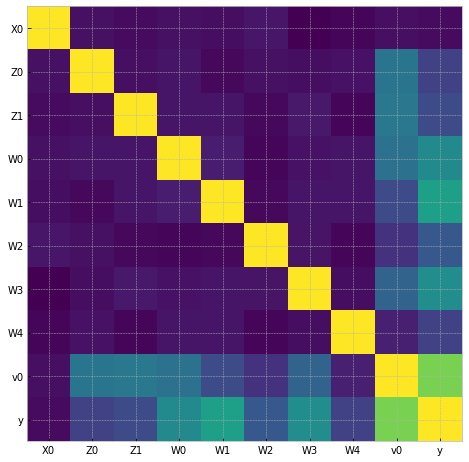

In [72]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(c)
ax.set(xticks=range(len(df.columns)), xticklabels=df.columns,
       yticks=range(len(df.columns)), yticklabels=df.columns)
plt.show()

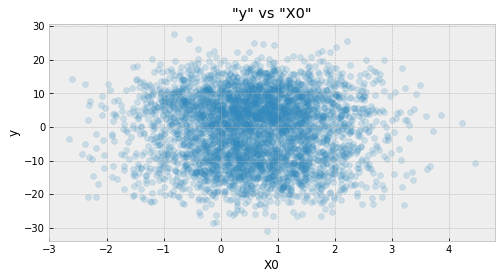

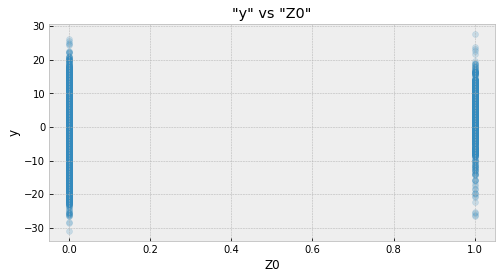

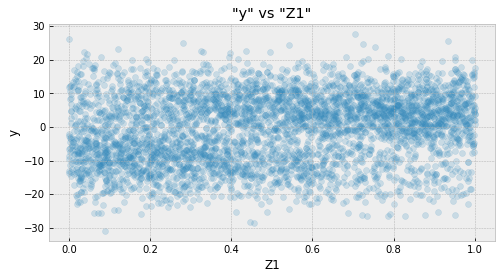

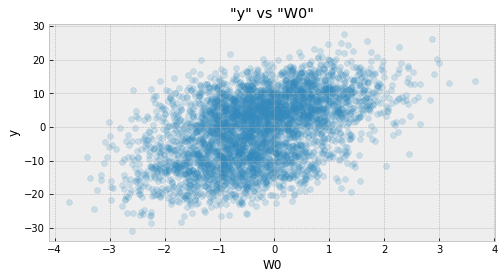

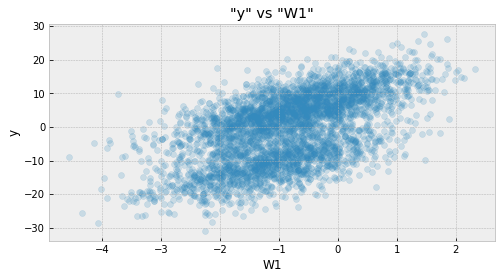

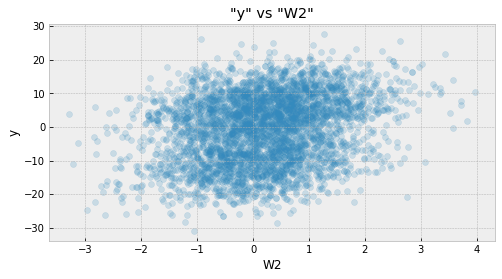

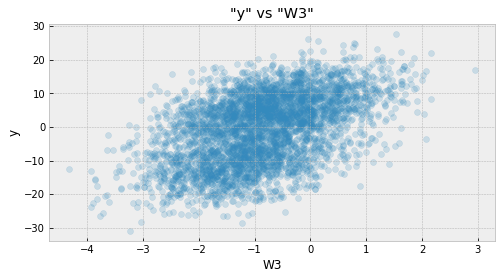

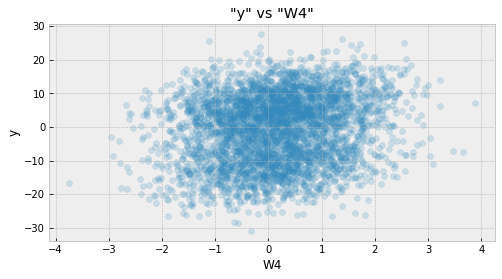

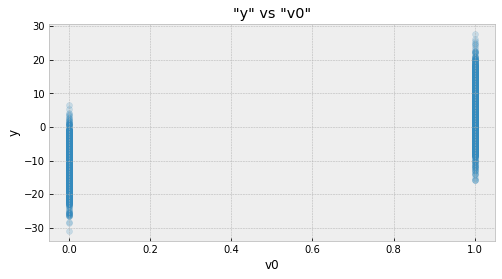

In [73]:
target = 'y'
for col in df.columns:
    if col == target: continue
    fig, ax = plt.subplots(figsize=(8,4))
    ax.scatter(col, target, data=df, alpha=.2)
    ax.set(xlabel=col, ylabel=target, title=f'"{target}" vs "{col}"')
    plt.show()

### Random forest and feature importance

In [74]:
x_cols = [col for col in df.columns if col != target]
X, y = df.loc[:, x_cols].values, df.loc[:, [target]].values.ravel()
m = ensemble.RandomForestRegressor(max_features='sqrt', n_estimators=100, oob_score=True)
m.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [75]:
m.oob_score_

In [76]:
def get_feature_importance(m, X:np.ndarray, y:np.ndarray, x_cols:list):
    n_obs, n_row = X.shape
    scores = {}
    for i in range(n_row):
        _X = X.copy()
        np.random.shuffle(_X[:,i])
        _y = m.predict(_X)
        scores[i] = metrics.mean_squared_error(y, _y)
        
    scores = pd.DataFrame([{'variable': x_cols[i], 'feature_importance': scores[i]} for i in scores]) 
    scores.sort_values('feature_importance', ascending=False, inplace=True)
    return scores

In [77]:
%%time
fi = get_feature_importance(m, X, y, x_cols)

CPU times: user 531 ms, sys: 15.6 ms, total: 547 ms
Wall time: 541 ms


In [78]:
fi

,variable,feature_importance
8,v0,75.845847
4,W1,34.694396
6,W3,16.662974
3,W0,10.524335
5,W2,5.913617
7,W4,2.709646
2,Z1,1.295431
1,Z0,0.838305
0,X0,0.736759


In [79]:
_y = m.predict(X)

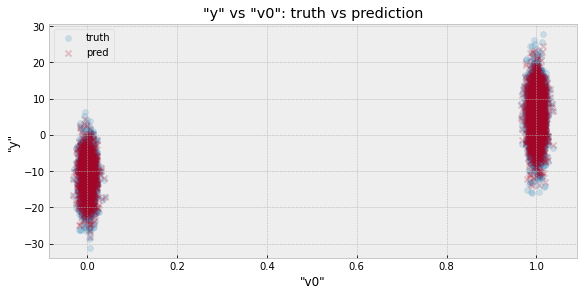

In [80]:
idp_var = 'v0'
ix = x_cols.index(idp_var)

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
jitter = np.random.normal(loc=0, scale=.01, size=len(y))
ax.scatter(X[:,ix]+jitter, y, label='truth', marker='o', alpha=.2)
ax.scatter(X[:,ix]+jitter, _y, label='pred', marker='x', alpha=.2)
ax.set(xlabel=f'"{idp_var}"', ylabel=f'"{target}"', 
       title=f'"{target}" vs "{idp_var}": truth vs prediction')
ax.legend(loc='best')
plt.show()

### dowhy things

Next:
* look into how the `linear_data` generates data exactly
* figure out what the output of `identify_effect` and `estimate_effect` mean

In [81]:
# With graph
model = CausalModel(data=df.copy(), treatment=lin_data['treatment_name'],
                    outcome=lin_data['outcome_name'], graph=lin_data['gml_graph'])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


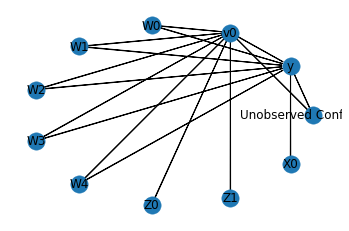

In [82]:
model.view_model()

Identification

'iv' = instrumental variable

In [83]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W4', 'W0', 'W3', 'W1', 'Unobserved Confounder']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



In [84]:
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name='backdoor.propensity_score_stratification')

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [95]:
?model.estimate_effect

In [85]:
print(causal_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
## Estimate
Value: 10.010713378747433



In [86]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1+w_random
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:(10.010713378747433,)
New effect:(10.038889917997942,)



Refute estimate tries to see which changes to the data / graph decrease or increase the estimate. The placebo approach is to replace the treatment, with a placebo. Which sounds alot like the feature importance approach where features are permuted one by one to see the worsening of the model predictions.

In [88]:
res_placebo = model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W4+W0+W3+W1
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:(10.010713378747433,)
New effect:(0.22221399758455707,)



Here the estimated effect significantly breaks down when using a placebo. Does this indicate that the treatment has a significant influence over the outcome?

In [90]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
print(res_subset)

Refute: Use a subset of data
Estimated effect:(10.010713378747433,)
New effect:(10.06868862942891,)

